<a href="https://colab.research.google.com/github/anushahulbatte/deeplearning/blob/main/Testing_with_GO_annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The session will have to be restarted when numpy gives an error.

Testing the performance of the ProteinCNN1D model on the GO annotation files. Hyperparameters were kept the same for the runs of the different GO terms. However, due to the presence of class imbalance, class weights was implemented to help improve the accuracy.
Confusion matrices and a classification report have been printed to visualise the performance of the model.
Judging the performance of the model only based on the accuracy with a highly imbalanced class is not correct, as it returns a high accuracy of the model predicting the over-represented class.
A confusion matrix was chosen to evaluate performance of the model on an imbalanced dataset and also based on various other metrics.

In [ ]:
import torch

if torch.__version__ != '2.5.1+cu124':
    !pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124 -U --quiet
    print("PyTorch version updated to 2.5.1.")
else:
    print("PyTorch is already at the correct version (2.5.1).")

PyTorch is already at the correct version (2.5.1).


In [ ]:
!pip install d2l==1.0.3 --quiet
!pip install scipy --quiet
!pip install torchmetrics --quiet

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler, random_split

from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

DEVICE = torch.device("cpu")

In [ ]:
import random
import os
import matplotlib.pyplot as plt
import csv
import numpy as np

In [ ]:
import os
! git clone https://git.wur.nl/bioinformatics/grs34806-deep-learning-project-data.git
os.chdir("grs34806-deep-learning-project-data")

fatal: destination path 'grs34806-deep-learning-project-data' already exists and is not an empty directory.


Read function is used to read the sequence files and the annotated GO terms file.
The function stores the sequences from the sequences file in a list and the identifiers in another list.
For identifiers from the sequences file if found inside the annotated GO terms, a 1 is used to denote this correspondance in a new list called labellist. 0 is used if the sequence identifier from the sequences file is not found in the annotated GO terms file.

In [ ]:
def read(seqfile, posfile):
  """
  Extracting the sequences from the seqfile and creating a list called datalist.
  Making a list called labellist containing 0s and 1s, where 1 denotes the
  sequence identifiers in the posfile.
  """
  # Removing the sequence identifiers
  with open(seqfile, 'r') as f:
    seq_lines = [seq_lines.strip() for seq_lines in f.readlines() if seq_lines.strip()]
    #print(seq_lines)
  seq_ids = []
  datalist = []
  current_seq = ""
  for line in seq_lines:
    if line.startswith("ENSG"):
      parts = line.split()
      #print(parts)
      seq_ids.append(parts[0])
      datalist.append(parts[1])

  with open(posfile, 'r') as f:
    annotated_ids = [line.strip() for line in f.readlines() if line.strip()]
    #print(annotated_ids)
  labellist = [1 if seq_id in annotated_ids else 0 for seq_id in seq_ids]

  print("Length of the datalist: ", len(datalist))
  print("Length of labellist: ", len(labellist))
  print("The number of positives in labellist: ", sum(labellist))
  #for i in range(min(5, len(datalist))):
        #print(f"ID: {seq_ids[i]}, Has annotation: {labellist[i]}, Sequence length: {len(datalist[i])}")

  return datalist, labellist


Testing with the sequence file as the positively annotated GO sequence identifiers for mitochondria.

In [ ]:
datalist, labellist = read(seqfile = "/content/grs34806-deep-learning-project-data/expr5Tseq_filtGO_100-1000.lis",
posfile = "/content/grs34806-deep-learning-project-data/GO_3A0005739.annotprot")


Length of the datalist:  6784
Length of labellist:  6784
The number of positives in labellist:  472


Splitting the sequences list and the label list into a training, validation and test set. This ensures the model can generalise well on unseen data and prevents it from overfitting.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def generate_train_val_test(datalist, labellist, test_size=0.2, val_size=0.25,
                            random_state=42):
  """
  First splitting the data into training and testing sets.
  And then separating the training set into a validation set.
  This is done in a 60%, 20% and 20% manner.
  """
  trainval_data, test_data, trainval_labels, test_labels = train_test_split(
      datalist, labellist, test_size=test_size,
      random_state = random_state
  )

  train_data, val_data, train_labels, val_labels = train_test_split(
      trainval_data, trainval_labels, test_size=val_size,
      random_state=random_state
  )

  return train_data, val_data, test_data, train_labels, val_labels, test_labels

In [ ]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = generate_train_val_test(
    datalist, labellist
)

In [ ]:

print("Training data size:", len(train_data))
print("Training labels size:", len(train_labels))
print("Validation data size: ", len(val_data))
print("Validation labels size: ", len(val_labels))
print("Test data size:", len(test_data))
print("Test labels size:", len(test_labels))

Training data size: 4070
Training labels size: 4070
Validation data size:  1357
Validation labels size:  1357
Test data size: 1357
Test labels size: 1357


Tokenise function maps the amino acids found in the sequences to unique integers. For amino acids which are not commonly found or are unknown, they take the default value of 20.

In [ ]:
def tokenize(dat, map2num, non_aa_num=20):
  """
  This function takes in the sequences of AA. It uses dictionary mapping, to map
  AA to integers. The non_aa_num make up the unknown AA, and its default value is
  20.
  """
  seq = []
  for count, i in enumerate(dat):
      seq.append([map2num.get(j, non_aa_num) for j in list(i)])
  return seq

This function ensures all the sequence lengths are the same. This is done by padding the sequences which are shorter. The sequences are then converted into tensors, which is the required form of the input for a CNN.

In [ ]:
def build_seq_array(lines, num_steps, non_aa_num=20):
  """
  This function applies the truncate_pad function to all the sequences.
  It then converts the sequences into tensors.
  """
  array = torch.tensor([
      truncate_pad(l, num_steps, non_aa_num) for l in lines])
  return array


In [ ]:
def truncate_pad(line, num_steps, padding_token):
  """
  The line in the parameters refers to the tokenized sequence.
  num_steps is the maxmimum sequence length. The padding_token is the integer
  for padding.
  The function pads shorter sequences with padding_token.
  """
  if len(line) > num_steps:
    return line[:num_steps] #Truncate
  return line + [padding_token] * (num_steps - len(line))


In [ ]:
from d2l import torch as d2l

Load function combines the above pre-defined function.
It includes some additional lines of code which are for converting the tensor into a one-hot encoded representation of the protein sequences, instead of having them as unique integers.

In [ ]:
def load_data(batch_size, num_steps, dataset, trainlabels = None):
  mapaa2num = {aa: i for (i, aa)
                      in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
  # Creating a dictionary which maps each AA to a unique integer
  seq, lab = dataset, trainlabels # lab is the labels which are associated with sequences

  seq = tokenize(seq, mapaa2num)
  seq_array = build_seq_array(seq, num_steps) # Shape = batch_size, num_steps

  # To convert the sequences to one-hot encoding
  # one_hot method takes a tensor and returns a tensor of shape of num_classes
  vocab_size = len(mapaa2num) +1
  seq_onehotencoding = F.one_hot(seq_array, num_classes=vocab_size).float()
  seq_onehotencoding = seq_onehotencoding.permute(0,2,1)
  # Shape = batch_size, vocab_size, num_steps

  data_arrays = (seq_onehotencoding, torch.tensor(lab))
  #data_arrays = (seq_array, torch.tensor(lab))
  data_iter = d2l.load_array(data_arrays, batch_size)
  #print("Shape of seq_array: ", seq_array.shape)
  #print("Shape of data_arrays, which now considers \none-hot encoded sequence: ",
        #seq_onehotencoding.shape)
  return data_iter

In [ ]:
print("Unique labels:", torch.unique(torch.tensor(train_labels)))

Unique labels: tensor([0, 1])


In [ ]:
train_iter = load_data(batch_size = 25, num_steps=20, dataset=train_data, trainlabels=train_labels)
validation_iter = load_data(batch_size=25, num_steps=20, dataset=val_data, trainlabels=val_labels)
test_iter = load_data(batch_size= 25, num_steps = 20, dataset = test_data, trainlabels = test_labels)

Defining the CNN model which will be used.
The architecture consists of 3 convolutional layers and 2 linear layers.

In [ ]:
class ProteinCNN1D(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=512,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4,
               momentum = 0):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=3,
                    padding='same',
                    bias=use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=256,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=256,
                    out_channels=128,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Flatten(),
          nn.Linear(in_features = int(128*(self.context_size//8)),
                    out_features = 256,
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(in_features = 256,
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None, pos_weight: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None
    if targets is not None:
      if pos_weight is not None:
        loss = F.binary_cross_entropy_with_logits(logits, targets.float(), pos_weight=pos_weight)
      else:
        loss = F.binary_cross_entropy_with_logits(logits, targets.float())
    return logits, loss



In [ ]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.2617, Validation Accuracy: 0.9197
Epoch 2: Train Loss: 0.2443, Validation Accuracy: 0.9197
Epoch 3: Train Loss: 0.2316, Validation Accuracy: 0.9197
Epoch 4: Train Loss: 0.2290, Validation Accuracy: 0.9197
Epoch 5: Train Loss: 0.2146, Validation Accuracy: 0.9197
Epoch 6: Train Loss: 0.2002, Validation Accuracy: 0.9197
Early stopping triggered at epoch 6

Final Test Accuracy: 0.9270


Epoch 1: Train Loss: 0.2663, Val Loss: 0.3840, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 2: Train Loss: 0.2423, Val Loss: 0.3104, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 3: Train Loss: 0.2223, Val Loss: 0.2806, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 4: Train Loss: 0.2267, Val Loss: 0.2851, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 5: Train Loss: 0.2113, Val Loss: 0.2848, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 6: Train Loss: 0.2082, Val Loss: 0.2622, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 7: Train Loss: 0.1875, Val Loss: 0.2823, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 8: Train Loss: 0.1770, Val Loss: 0.2871, Val Acc: 0.9182, Test Acc: 0.9278
Epoch 9: Train Loss: 0.1642, Val Loss: 0.2951, Val Acc: 0.9234, Test Acc: 0.9293
Epoch 10: Train Loss: 0.1607, Val Loss: 0.3019, Val Acc: 0.9219, Test Acc: 0.9293


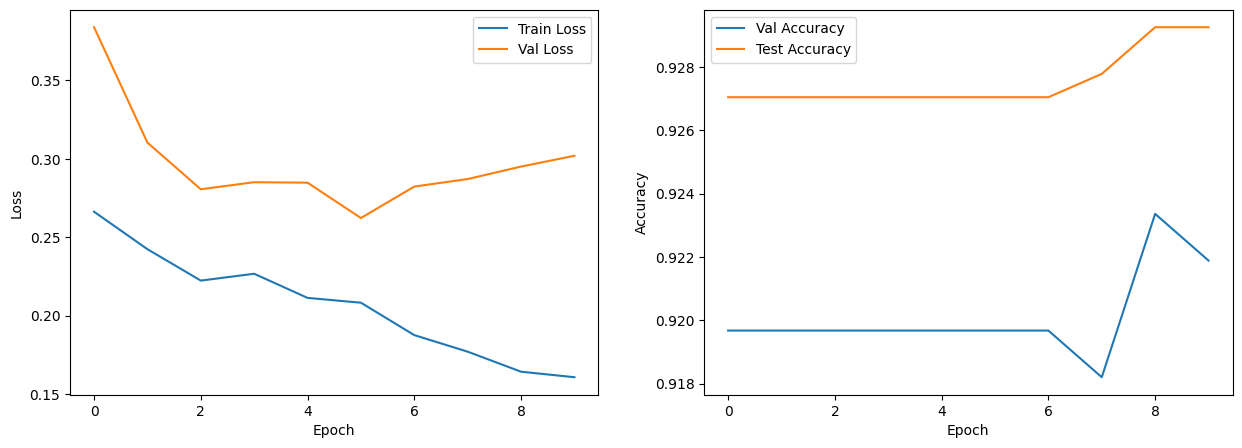

In [ ]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
def evaluate_with_confusion_matrix(model, data_iter):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, _ = model(X)
            preds = (torch.sigmoid(logits) > 0.5).float()  # Threshold at 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Return metrics (optional)
    accuracy = (all_preds == all_labels).mean()
    print(f"Test Accuracy: {accuracy:.4f}")
    return cm

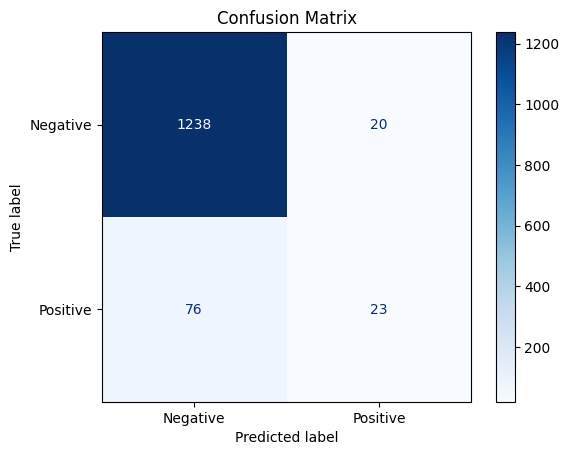

Test Accuracy: 0.9293


In [ ]:
test_cm = evaluate_with_confusion_matrix(model, test_iter)

Due to a highly imbalanced dataset, only a very few positively annotated sequences, the model is good at predicting the 0s but it fails to predicts the 1s. To address this, we make use of class weighting.
The number of epochs have also been increased to give the model more training time and learning is not linear.

In [ ]:
from sklearn.metrics import classification_report

Epoch 30 | Train Loss: 0.3876 | Val Loss: 1.6505 | Val Acc: 0.8452 | Test Acc: 0.8430
              precision    recall  f1-score   support

           0     0.9604    0.8665    0.9110      1258
           1     0.2432    0.5455    0.3364        99

    accuracy                         0.8430      1357
   macro avg     0.6018    0.7060    0.6237      1357
weighted avg     0.9080    0.8430    0.8691      1357



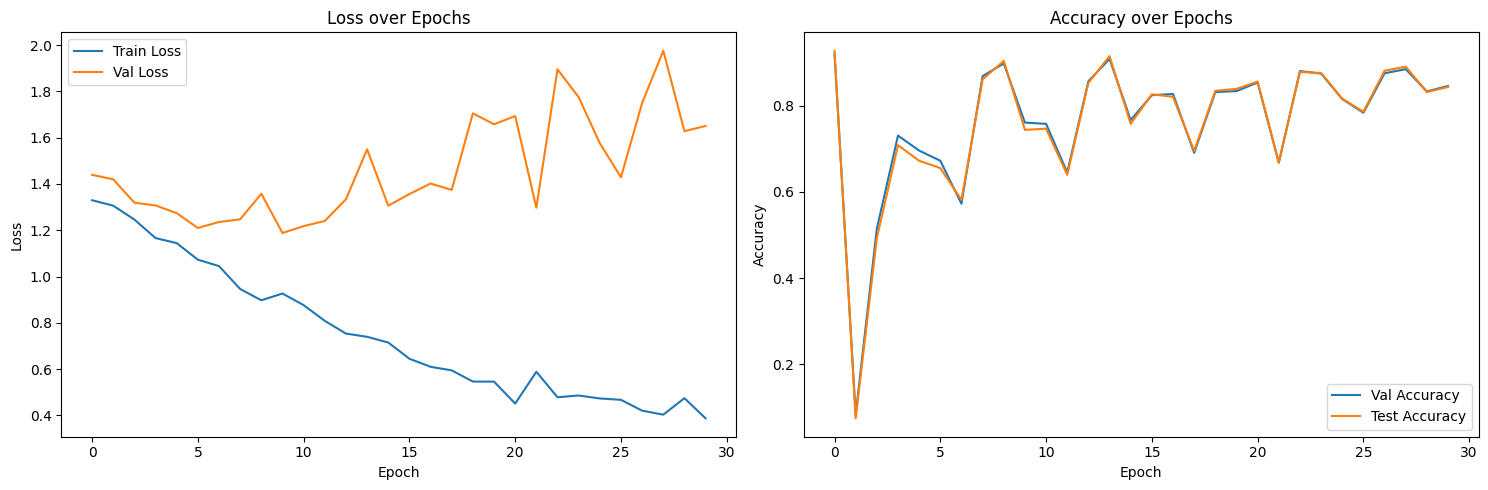

In [ ]:
# Defining the hyperparameters
batch_size = 32
context_size = 100
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 30
weight_decay = 1e-4

# Loading the datasets
train_iter = load_data(batch_size, context_size, train_data, train_labels)
val_iter   = load_data(batch_size, context_size, val_data, val_labels)
test_iter  = load_data(batch_size, context_size, test_data, test_labels)

# Initializing the model
model = ProteinCNN1D(vocab_size=21, context_size=context_size, conv_channels=512, use_bias=False)
model.to(DEVICE)

# Initializing the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Computing pos_weight for class weights to aid with the imbalance in the
# 1s and 0s
neg_count = train_labels.count(0)
pos_count = train_labels.count(1)
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float).to(DEVICE)

# Initialising empty lists to store the results for further visualisation
train_losses, val_losses, val_accuracies, test_losses, test_accuracies = [], [], [], [], []

# Defining an evaluation loop
def evaluate(model, data_iter, pos_weight):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y, pos_weight=pos_weight)
            total_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
            correct += (preds == y.cpu().numpy()).sum()
            total += y.size(0)
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())

    acc = correct / total
    return total_loss / len(data_iter), acc, all_labels, all_preds

# Initialising the training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y, pos_weight=pos_weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / len(train_iter)
    train_acc = correct / total
    train_losses.append(train_loss)

    val_loss, val_acc, _, _ = evaluate(model, val_iter, pos_weight)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    test_loss, test_acc, all_labels, all_preds = evaluate(model, test_iter, pos_weight)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

# Printing the values the different losses
print(f'Epoch {epoch+1:02d} | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Val Acc: {val_acc:.4f} | '
          f'Test Acc: {test_acc:.4f}')

print(classification_report(all_labels, all_preds, digits=4))

# Plotting a graph to visualise the trend of the training set loss and the
# validation set loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss over Epochs")
plt.legend()

# Plotting a graph to visualise the trend of the validation set and the test set
# accuracies
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()



Final classification report on the test set:
              precision    recall  f1-score   support

           0     0.9604    0.8665    0.9110      1258
           1     0.2432    0.5455    0.3364        99

    accuracy                         0.8430      1357
   macro avg     0.6018    0.7060    0.6237      1357
weighted avg     0.9080    0.8430    0.8691      1357

Confusion Matrix:
[[1090  168]
 [  45   54]]
True Positives (TP): 54
False Positives (FP): 168
True Negatives (TN): 1090
False Negatives (FN): 45


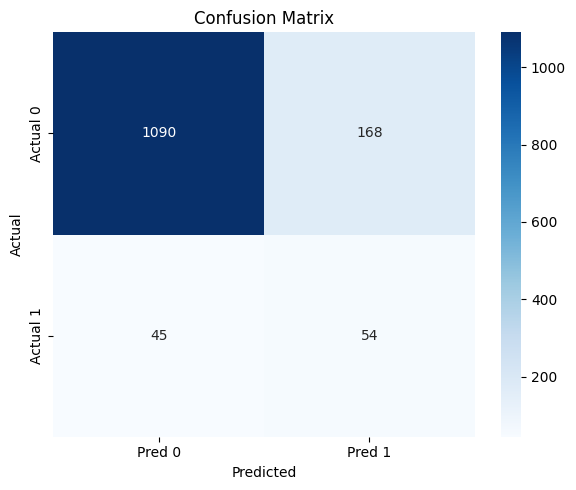

In [ ]:
from sklearn.metrics import confusion_matrix

# Printing a classification report to get more idea on the performance of the model
# with the help of other metrics
print("\nFinal classification report on the test set:")
print(classification_report(all_labels, all_preds, digits=4))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

tn, fp, fn, tp = cm.ravel()
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


The new confusion matrix shows the model now performs somewhat better when predicting the 1s compared to the confusion matrix plotted earlier.
On computing the class weights, it applies a heavy penalisation on wrongly classifying 1s.
The model still shows high accuracy due to its ability to predict 0s very well.
To better understand its performance the classification report is used, which shows the recall and F1-score for both 0 and 1 labels. From the report we can see that the recall and F1-score for label 1 is not as high as the ones for label 0. However, the recall is slightly higher than 0.5, highlighting that there are more chances of improvement.

Trying with the signal transduction GO annotations.

In [ ]:
datalist, labellist = read(seqfile = "/content/grs34806-deep-learning-project-data/expr5Tseq_filtGO_100-1000.lis",
posfile = "/content/grs34806-deep-learning-project-data/GO_3A0007165.annotprot")


Length of the datalist:  6784
Length of labellist:  6784
The number of positives in labellist:  420


In [ ]:
train_data_signal, val_data_signal, test_data_signal, train_labels_signal, val_labels_signal, test_labels_signal = generate_train_val_test(
    datalist, labellist
)

In [ ]:
print("Training data size:", len(train_data_signal))
print("Training labels size:", len(train_labels_signal))
print("Validation data size: ", len(val_data_signal))
print("Validation labels size: ", len(val_labels_signal))
print("Test data size:", len(test_data_signal))
print("Test labels size:", len(test_labels_signal))

Training data size: 4070
Training labels size: 4070
Validation data size:  1357
Validation labels size:  1357
Test data size: 1357
Test labels size: 1357


Epoch 30 | Train Loss: 1.2589 | Val Loss: 1.4311 | Val Acc: 0.9462 | Test Acc: 0.9359
              precision    recall  f1-score   support

           0     0.9359    1.0000    0.9669      1270
           1     0.0000    0.0000    0.0000        87

    accuracy                         0.9359      1357
   macro avg     0.4679    0.5000    0.4834      1357
weighted avg     0.8759    0.9359    0.9049      1357



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


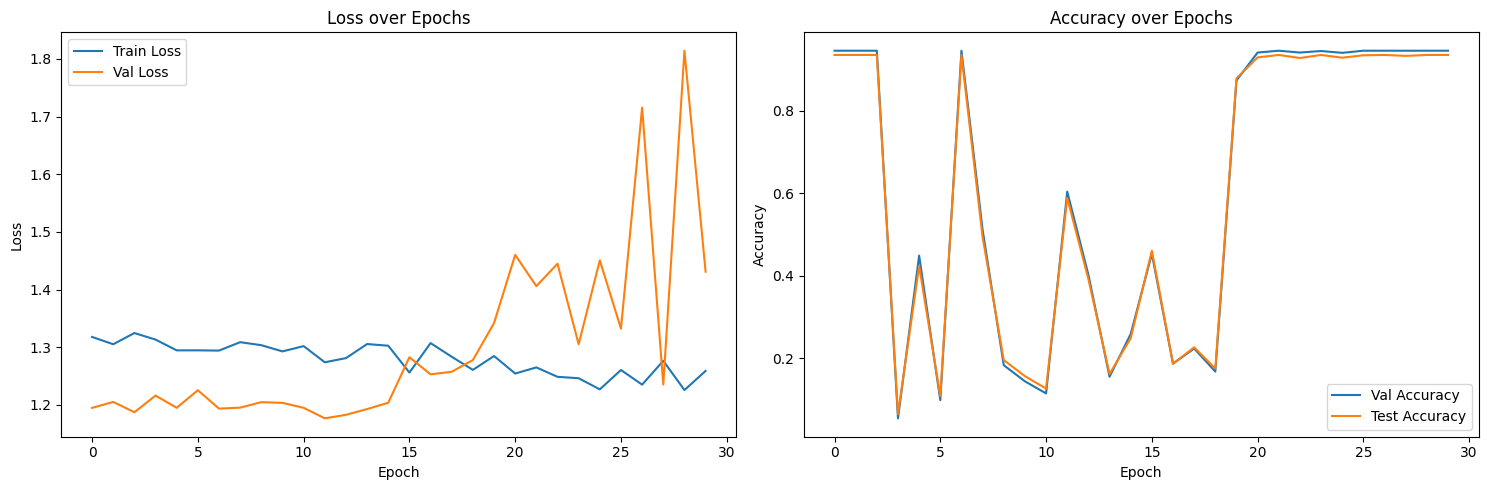

In [ ]:
# Defining the hyperparameters
batch_size = 32
context_size = 100
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 30
weight_decay = 1e-4

# Loading the datasets
train_iter = load_data(batch_size, context_size, train_data_signal, train_labels_signal)
val_iter   = load_data(batch_size, context_size, val_data_signal, val_labels_signal)
test_iter  = load_data(batch_size, context_size, test_data_signal, test_labels_signal)

# Initializing the model
model = ProteinCNN1D(vocab_size=21, context_size=context_size, conv_channels=512, use_bias=False)
model.to(DEVICE)

# Initializing the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Computing the pos_weight for class weight calculation
neg_count = train_labels_signal.count(0)
pos_count = train_labels_signal.count(1)
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float).to(DEVICE)

# Storing the results in empty lists for further visualisation
train_losses, val_losses, val_accuracies, test_losses, test_accuracies = [], [], [], [], []

# Defining the evaluation loop
def evaluate(model, data_iter, pos_weight):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y, pos_weight=pos_weight)
            total_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
            correct += (preds == y.cpu().numpy()).sum()
            total += y.size(0)
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())

    acc = correct / total
    return total_loss / len(data_iter), acc, all_labels, all_preds

# Initializing the training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y, pos_weight=pos_weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / len(train_iter)
    train_acc = correct / total
    train_losses.append(train_loss)

    val_loss, val_acc, _, _ = evaluate(model, val_iter, pos_weight)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    test_loss, test_acc, all_labels, all_preds = evaluate(model, test_iter, pos_weight)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)


print(f'Epoch {epoch+1:02d} | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Val Acc: {val_acc:.4f} | '
          f'Test Acc: {test_acc:.4f}')

print(classification_report(all_labels, all_preds, digits=4))

# Plotting a graph to visualise the trend of the training set loss and the
# validation set loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss over Epochs")
plt.legend()

# Plotting a graph to visualise the trend of the validation set and the test set
# accuracies
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()



Final classification report on the test set:
              precision    recall  f1-score   support

           0     0.9359    1.0000    0.9669      1270
           1     0.0000    0.0000    0.0000        87

    accuracy                         0.9359      1357
   macro avg     0.4679    0.5000    0.4834      1357
weighted avg     0.8759    0.9359    0.9049      1357

Confusion Matrix:
[[1270    0]
 [  87    0]]
True Positives (TP): 0
False Positives (FP): 0
True Negatives (TN): 1270
False Negatives (FN): 87


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


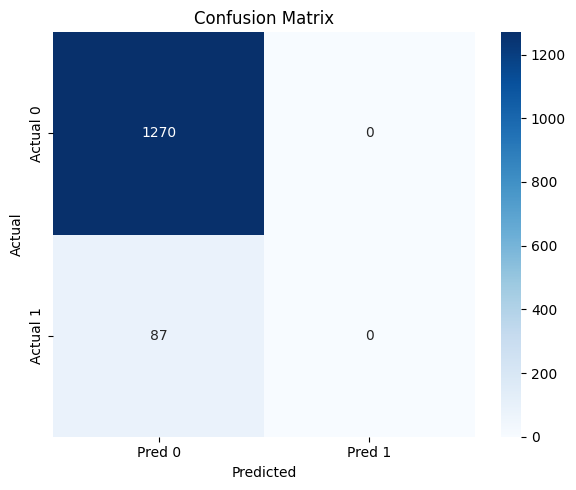

In [ ]:
from sklearn.metrics import confusion_matrix

# Printing a classification report to get more idea on the performance of the model
# with the help of other metrics
print("\nFinal classification report on the test set:")
print(classification_report(all_labels, all_preds, digits=4))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

tn, fp, fn, tp = cm.ravel()
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


Running the model on extracellular region GO anotation file

In [ ]:
datalist, labellist = read(seqfile = "/content/grs34806-deep-learning-project-data/expr5Tseq_filtGO_100-1000.lis",
posfile = "/content/grs34806-deep-learning-project-data/GO_3A0005576.annotprot")


Length of the datalist:  6784
Length of labellist:  6784
The number of positives in labellist:  307


In [ ]:
train_data_extracellular, val_data_extracellular, test_data_extracellular, train_labels_extracellular, val_labels_extracellular, test_labels_extracellular = generate_train_val_test(datalist, labellist)

In [ ]:
print("Training data size:", len(train_data_extracellular))
print("Training labels size:", len(train_labels_extracellular))
print("Validation data size: ", len(val_data_extracellular))
print("Validation labels size: ", len(val_labels_extracellular))
print("Test data size:", len(test_data_extracellular))
print("Test labels size:", len(test_labels_extracellular))

Training data size: 4070
Training labels size: 4070
Validation data size:  1357
Validation labels size:  1357
Test data size: 1357
Test labels size: 1357


Epoch 30 | Train Loss: 0.3205 | Val Loss: 0.9403 | Val Acc: 0.8659 | Test Acc: 0.8732
              precision    recall  f1-score   support

           0     0.9820    0.8838    0.9303      1299
           1     0.1968    0.6379    0.3008        58

    accuracy                         0.8732      1357
   macro avg     0.5894    0.7608    0.6156      1357
weighted avg     0.9485    0.8732    0.9034      1357



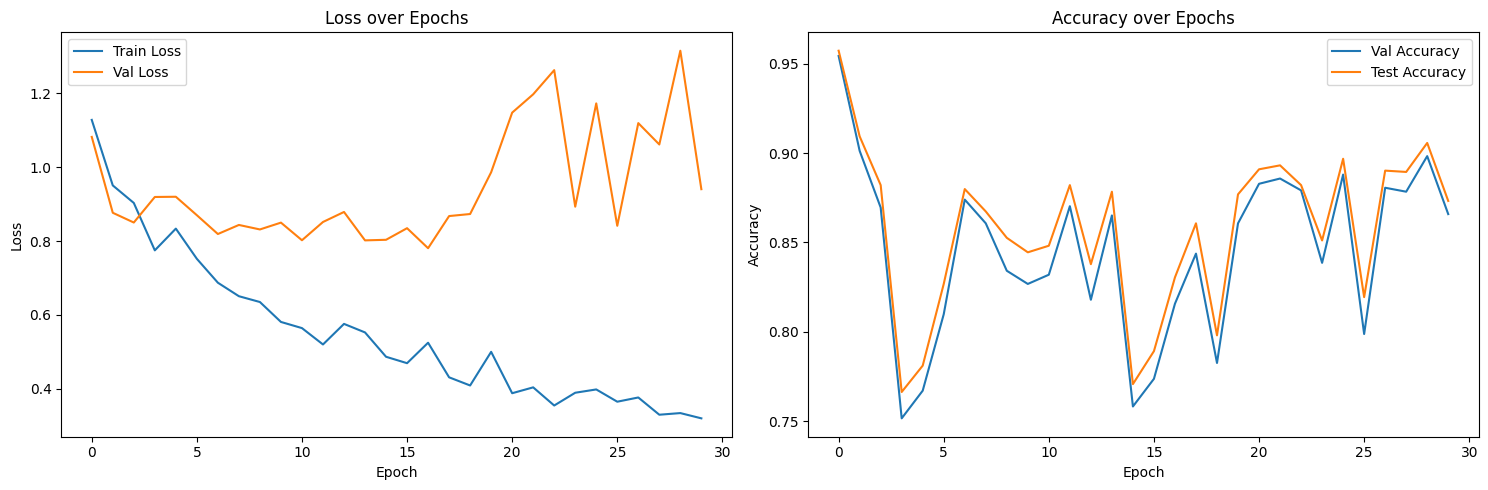

In [ ]:
# Defining the hyperparameters
batch_size = 32
context_size = 100
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 30
weight_decay = 1e-4

# Loading the datasets
train_iter_ec = load_data(batch_size, context_size, train_data_extracellular, train_labels_extracellular)
val_iter_ec   = load_data(batch_size, context_size, val_data_extracellular, val_labels_extracellular)
test_iter_ec  = load_data(batch_size, context_size, test_data_extracellular, test_labels_extracellular)

# Initializing the model
model = ProteinCNN1D(vocab_size=21, context_size=context_size, conv_channels=512, use_bias=False)
model.to(DEVICE)

# Initializing the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Computing the pos_weight for class weight calculation
neg_count = train_labels_signal.count(0)
pos_count = train_labels_signal.count(1)
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float).to(DEVICE)

# Storing the results in empty lists for further visualisation
train_losses, val_losses, val_accuracies, test_losses, test_accuracies = [], [], [], [], []

# Defining the evaluation loop
def evaluate(model, data_iter, pos_weight):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y, pos_weight=pos_weight)
            total_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
            correct += (preds == y.cpu().numpy()).sum()
            total += y.size(0)
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())

    acc = correct / total
    return total_loss / len(data_iter), acc, all_labels, all_preds

# Initializing the training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in train_iter_ec:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y, pos_weight=pos_weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / len(train_iter_ec)
    train_acc = correct / total
    train_losses.append(train_loss)

    val_loss, val_acc, _, _ = evaluate(model, val_iter_ec, pos_weight)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    test_loss, test_acc, all_labels, all_preds = evaluate(model, test_iter_ec, pos_weight)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)


print(f'Epoch {epoch+1:02d} | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Val Acc: {val_acc:.4f} | '
          f'Test Acc: {test_acc:.4f}')

print(classification_report(all_labels, all_preds, digits=4))

# Plotting a graph to visualise the trend of the training set loss and the
# validation set loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss over Epochs")
plt.legend()

# Plotting a graph to visualise the trend of the validation set and the test set
# accuracies
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()



Final classification report on the test set:
              precision    recall  f1-score   support

           0     0.9820    0.8838    0.9303      1299
           1     0.1968    0.6379    0.3008        58

    accuracy                         0.8732      1357
   macro avg     0.5894    0.7608    0.6156      1357
weighted avg     0.9485    0.8732    0.9034      1357

Confusion Matrix:
[[1148  151]
 [  21   37]]
True Positives (TP): 37
False Positives (FP): 151
True Negatives (TN): 1148
False Negatives (FN): 21


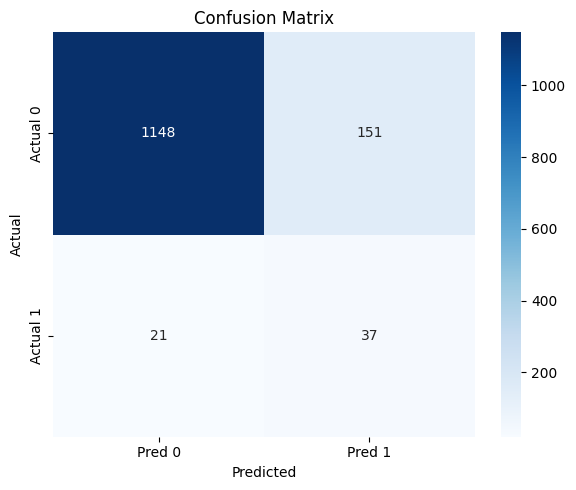

In [ ]:
from sklearn.metrics import confusion_matrix

# Printing a classification report to get more idea on the performance of the model
# with the help of other metrics
print("\nFinal classification report on the test set:")
print(classification_report(all_labels, all_preds, digits=4))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

tn, fp, fn, tp = cm.ravel()
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


Running the model on Transmembrane transport GO annotation file

In [ ]:
datalist, labellist = read(seqfile = "/content/grs34806-deep-learning-project-data/expr5Tseq_filtGO_100-1000.lis",
posfile = "/content/grs34806-deep-learning-project-data/GO_3A0055085.annotprot")

Length of the datalist:  6784
Length of labellist:  6784
The number of positives in labellist:  226


In [ ]:
train_data_tmt, val_data_tmt, test_data_tmt, train_labels_tmt, val_labels_tmt, test_labels_tmt =generate_train_val_test(datalist, labellist)

In [ ]:
print("Training data size:", len(train_data_tmt))
print("Training labels size:", len(train_labels_tmt))
print("Validation data size: ", len(val_data_tmt))
print("Validation labels size: ", len(val_labels_tmt))
print("Test data size:", len(test_data_tmt))
print("Test labels size:", len(test_labels_tmt))

Training data size: 4070
Training labels size: 4070
Validation data size:  1357
Validation labels size:  1357
Test data size: 1357
Test labels size: 1357


Epoch 30 | Train Loss: 0.1538 | Val Loss: 1.6042 | Val Acc: 0.9506 | Test Acc: 0.9521
              precision    recall  f1-score   support

           0     0.9735    0.9772    0.9753      1315
           1     0.1892    0.1667    0.1772        42

    accuracy                         0.9521      1357
   macro avg     0.5813    0.5719    0.5763      1357
weighted avg     0.9492    0.9521    0.9506      1357



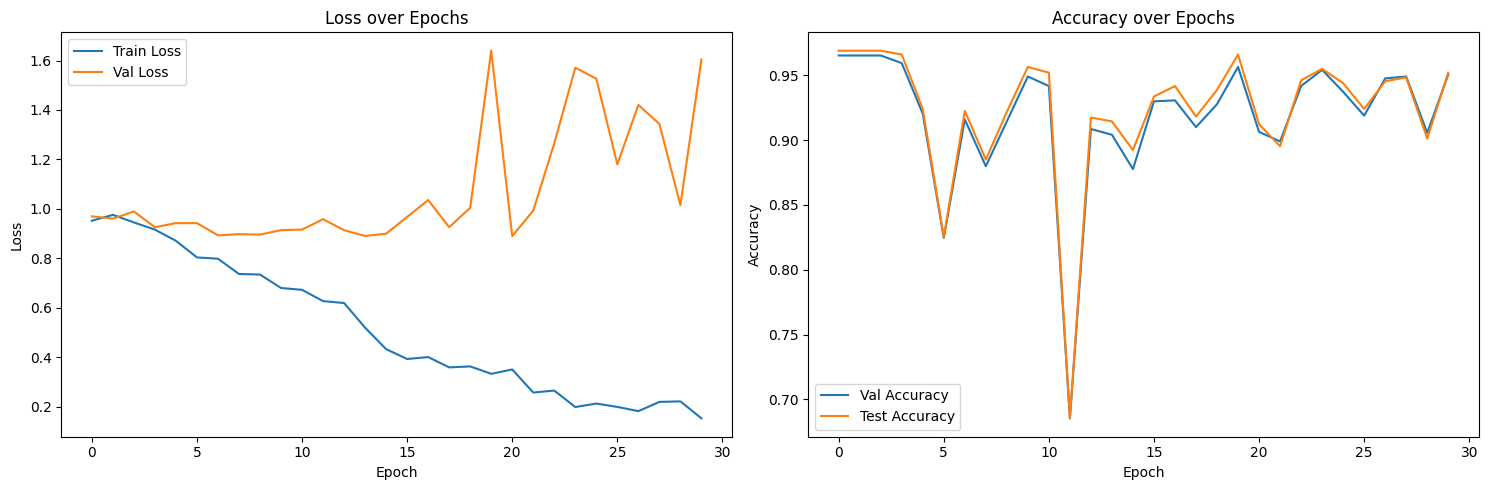

In [ ]:
# Defining the hyperparameters
batch_size = 32
context_size = 100
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 30
weight_decay = 1e-4

# Loading the datasets
train_iter_transmembrane = load_data(batch_size, context_size, train_data_tmt, train_labels_tmt)
val_iter_transmembrane   = load_data(batch_size, context_size, val_data_tmt, val_labels_tmt)
test_iter_transmembrane  = load_data(batch_size, context_size, test_data_tmt, test_labels_tmt)

# Initializing the model
model = ProteinCNN1D(vocab_size=21, context_size=context_size, conv_channels=512, use_bias=False)
model.to(DEVICE)

# Initializing the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Computing the pos_weight for class weight calculation
neg_count = train_labels_signal.count(0)
pos_count = train_labels_signal.count(1)
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float).to(DEVICE)

# Storing the results in empty lists for further visualisation
train_losses, val_losses, val_accuracies, test_losses, test_accuracies = [], [], [], [], []

# Defining the evaluation loop
def evaluate(model, data_iter, pos_weight):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y, pos_weight=pos_weight)
            total_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
            correct += (preds == y.cpu().numpy()).sum()
            total += y.size(0)
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())

    acc = correct / total
    return total_loss / len(data_iter), acc, all_labels, all_preds

# Initializing the training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in train_iter_transmembrane:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y, pos_weight=pos_weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / len(train_iter_transmembrane)
    train_acc = correct / total
    train_losses.append(train_loss)

    val_loss, val_acc, _, _ = evaluate(model, val_iter_transmembrane, pos_weight)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    test_loss, test_acc, all_labels, all_preds = evaluate(model, test_iter_transmembrane, pos_weight)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)


print(f'Epoch {epoch+1:02d} | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Val Acc: {val_acc:.4f} | '
          f'Test Acc: {test_acc:.4f}')

print(classification_report(all_labels, all_preds, digits=4))

# Plotting a graph to visualise the trend of the training set loss and the
# validation set loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss over Epochs")
plt.legend()

# Plotting a graph to visualise the trend of the validation set and the test set
# accuracies
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()



Final classification report on the test set:
              precision    recall  f1-score   support

           0     0.9735    0.9772    0.9753      1315
           1     0.1892    0.1667    0.1772        42

    accuracy                         0.9521      1357
   macro avg     0.5813    0.5719    0.5763      1357
weighted avg     0.9492    0.9521    0.9506      1357

Confusion Matrix:
[[1285   30]
 [  35    7]]
True Positives (TP): 7
False Positives (FP): 30
True Negatives (TN): 1285
False Negatives (FN): 35


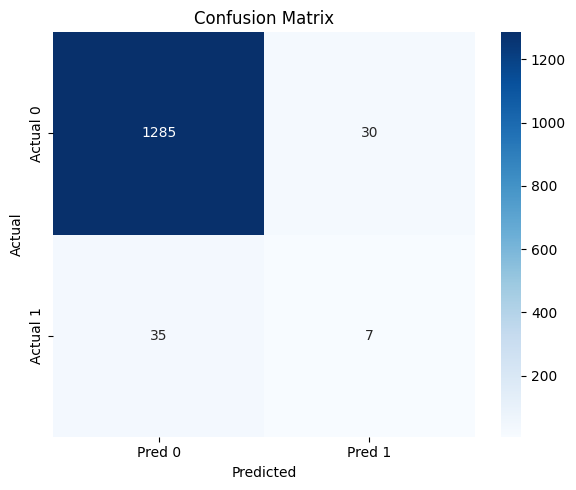

In [ ]:
from sklearn.metrics import confusion_matrix

# Printing a classification report to get more idea on the performance of the model
# with the help of other metrics
print("\nFinal classification report on the test set:")
print(classification_report(all_labels, all_preds, digits=4))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

tn, fp, fn, tp = cm.ravel()
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


Running the model on the negative regulation of apoptotic process GO annotation file

In [ ]:
datalist, labellist = read(seqfile = "/content/grs34806-deep-learning-project-data/expr5Tseq_filtGO_100-1000.lis",
posfile = "/content/grs34806-deep-learning-project-data/GO_3A0043066.annotprot")

Length of the datalist:  6784
Length of labellist:  6784
The number of positives in labellist:  190


In [ ]:
train_data_regulation, val_data_regulation, test_data_regulation,train_labels_regulation, val_labels_regulation, test_labels_regulation =generate_train_val_test(datalist, labellist)

In [ ]:
print("Training data size:", len(train_data_regulation))
print("Training labels size:", len(train_labels_regulation))
print("Validation data size: ", len(val_data_regulation))
print("Validation labels size: ", len(val_labels_regulation))
print("Test data size:", len(test_data_regulation))
print("Test labels size:", len(test_labels_regulation))

Training data size: 4070
Training labels size: 4070
Validation data size:  1357
Validation labels size:  1357
Test data size: 1357
Test labels size: 1357


Epoch 30 | Train Loss: 0.1181 | Val Loss: 2.2426 | Val Acc: 0.9528 | Test Acc: 0.9573
              precision    recall  f1-score   support

           0     0.9767    0.9796    0.9782      1326
           1     0.0000    0.0000    0.0000        31

    accuracy                         0.9573      1357
   macro avg     0.4883    0.4898    0.4891      1357
weighted avg     0.9544    0.9573    0.9558      1357



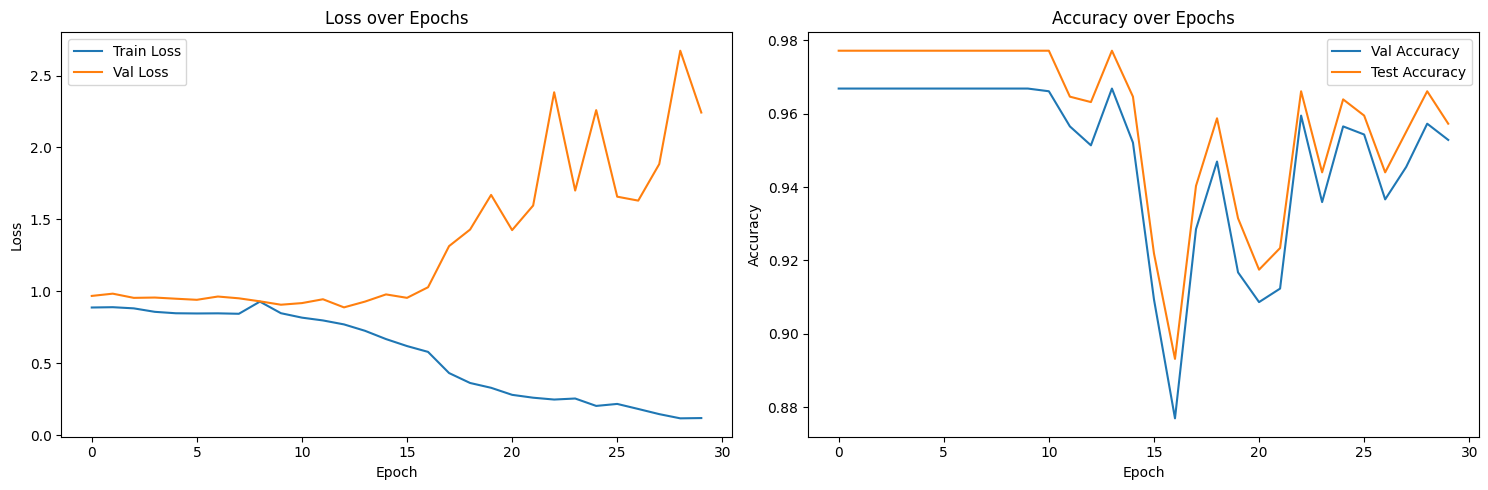

In [ ]:
# Defining the hyperparameters
batch_size = 32
context_size = 100
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 30
weight_decay = 1e-4

# Loading the datasets
train_iter_reg = load_data(batch_size, context_size, train_data_regulation, train_labels_regulation)
val_iter_reg   = load_data(batch_size, context_size, val_data_regulation, val_labels_regulation)
test_iter_reg = load_data(batch_size, context_size, test_data_regulation, test_labels_regulation)

# Initializing the model
model = ProteinCNN1D(vocab_size=21, context_size=context_size, conv_channels=512, use_bias=False)
model.to(DEVICE)

# Initializing the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Computing the pos_weight for class weight calculation
neg_count = train_labels_signal.count(0)
pos_count = train_labels_signal.count(1)
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float).to(DEVICE)

# Storing the results in empty lists for further visualisation
train_losses, val_losses, val_accuracies, test_losses, test_accuracies = [], [], [], [], []

# Defining the evaluation loop
def evaluate(model, data_iter, pos_weight):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y, pos_weight=pos_weight)
            total_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
            correct += (preds == y.cpu().numpy()).sum()
            total += y.size(0)
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())

    acc = correct / total
    return total_loss / len(data_iter), acc, all_labels, all_preds

# Initializing the training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in train_iter_reg:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y, pos_weight=pos_weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / len(train_iter_reg)
    train_acc = correct / total
    train_losses.append(train_loss)

    val_loss, val_acc, _, _ = evaluate(model, val_iter_reg, pos_weight)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    test_loss, test_acc, all_labels, all_preds = evaluate(model, test_iter_reg, pos_weight)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)


print(f'Epoch {epoch+1:02d} | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Val Acc: {val_acc:.4f} | '
          f'Test Acc: {test_acc:.4f}')

print(classification_report(all_labels, all_preds, digits=4))

# Plotting a graph to visualise the trend of the training set loss and the
# validation set loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss over Epochs")
plt.legend()

# Plotting a graph to visualise the trend of the validation set and the test set
# accuracies
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()



Final classification report on the test set:
              precision    recall  f1-score   support

           0     0.9767    0.9796    0.9782      1326
           1     0.0000    0.0000    0.0000        31

    accuracy                         0.9573      1357
   macro avg     0.4883    0.4898    0.4891      1357
weighted avg     0.9544    0.9573    0.9558      1357

Confusion Matrix:
[[1299   27]
 [  31    0]]
True Positives (TP): 0
False Positives (FP): 27
True Negatives (TN): 1299
False Negatives (FN): 31


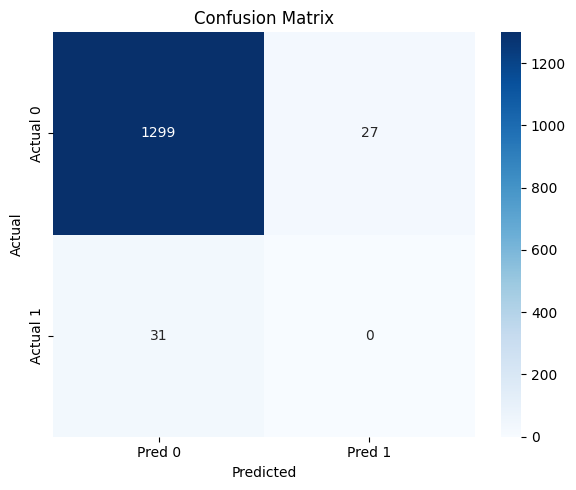

In [ ]:
from sklearn.metrics import confusion_matrix

# Printing a classification report to get more idea on the performance of the model
# with the help of other metrics
print("\nFinal classification report on the test set:")
print(classification_report(all_labels, all_preds, digits=4))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

tn, fp, fn, tp = cm.ravel()
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


The model was also run on the 14,765 human proteins to check the performance of the model. The functions defined below have been adapted to only process this file, as there is no annotation file.

In [ ]:
seqfile = '/content/grs34806-deep-learning-project-data/test_set_filt.f'

In [ ]:
def read(seqfile):
  """
  Extracting the sequences from the seqfile and creating a list called datalist.
  Making a list called labellist containing 0s and 1s, where 1 denotes the
  sequence identifiers in the posfile.
  """
  datalist = []
  seq_ids = []

  with open(seqfile, 'r') as file:
    seq = ''
    for line in file:
      line = line.strip()
      if line.startswith('>'):
        if seq:
          datalist.append(seq)
          seq = ''
        seq_ids.append(line[1:])
      else:
        seq += line
    if seq:
      datalist.append(seq)

  # print(datalist)
  # print(seq_ids)
  return datalist


In [ ]:
datalist = read(seqfile)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def generate_train_val_test(sequences, test_size=0.2, val_size=0.25,
                            random_state=42):
  """
  First splitting the data into training and testing sets.
  And then separating the training set into a validation set.
  This is done in a 60%, 20% and 20% manner.
  """
  trainval_data, remaining_data = train_test_split(sequences, test_size=test_size, random_state=random_state)

  val_data, test_data = train_test_split(remaining_data, test_size=val_size, random_state=random_state)


  return train_data, val_data, test_data

In [ ]:
train_data, val_data, test_data = generate_train_val_test(datalist)

In [ ]:
def load_data(batch_size, num_steps, dataset):
    mapaa2num = {aa: i for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}

    seq = dataset
    seq = tokenize(seq, mapaa2num)
    seq_array = build_seq_array(seq, num_steps)
    vocab_size = len(mapaa2num) + 1
    seq_onehotencoding = F.one_hot(seq_array, num_classes=vocab_size).float()
    seq_onehotencoding = seq_onehotencoding.permute(0, 2, 1)

    data_arrays = (seq_onehotencoding, )
    data_iter = d2l.load_array(data_arrays, batch_size)

    return data_iter

In [ ]:
batch_size = 32
num_steps = 100
train_iter = load_data(batch_size, num_steps, train_data)
val_iter = load_data(batch_size, num_steps, val_data)
test_iter = load_data(batch_size, num_steps, test_data)

Epoch 01 | Train Loss: 0.9317 | Val Loss: 0.9524 | Val Acc: 0.9668 | Test Acc: 0.9772
Epoch 02 | Train Loss: 0.8719 | Val Loss: 0.9200 | Val Acc: 0.9668 | Test Acc: 0.9772
Epoch 03 | Train Loss: 0.8979 | Val Loss: 0.9537 | Val Acc: 0.9668 | Test Acc: 0.9772
Epoch 04 | Train Loss: 0.8779 | Val Loss: 0.9507 | Val Acc: 0.9668 | Test Acc: 0.9772
Epoch 05 | Train Loss: 0.8442 | Val Loss: 0.9432 | Val Acc: 0.9668 | Test Acc: 0.9772
Epoch 06 | Train Loss: 0.8561 | Val Loss: 0.9295 | Val Acc: 0.9668 | Test Acc: 0.9772
Epoch 07 | Train Loss: 0.8269 | Val Loss: 0.9377 | Val Acc: 0.9668 | Test Acc: 0.9772
Epoch 08 | Train Loss: 0.8313 | Val Loss: 0.9198 | Val Acc: 0.9668 | Test Acc: 0.9772
Epoch 09 | Train Loss: 0.8093 | Val Loss: 0.9272 | Val Acc: 0.9668 | Test Acc: 0.9772
Epoch 10 | Train Loss: 0.7956 | Val Loss: 0.9089 | Val Acc: 0.9668 | Test Acc: 0.9772
Epoch 11 | Train Loss: 0.8157 | Val Loss: 0.8942 | Val Acc: 0.9646 | Test Acc: 0.9764
Epoch 12 | Train Loss: 0.9075 | Val Loss: 0.9076 | Val

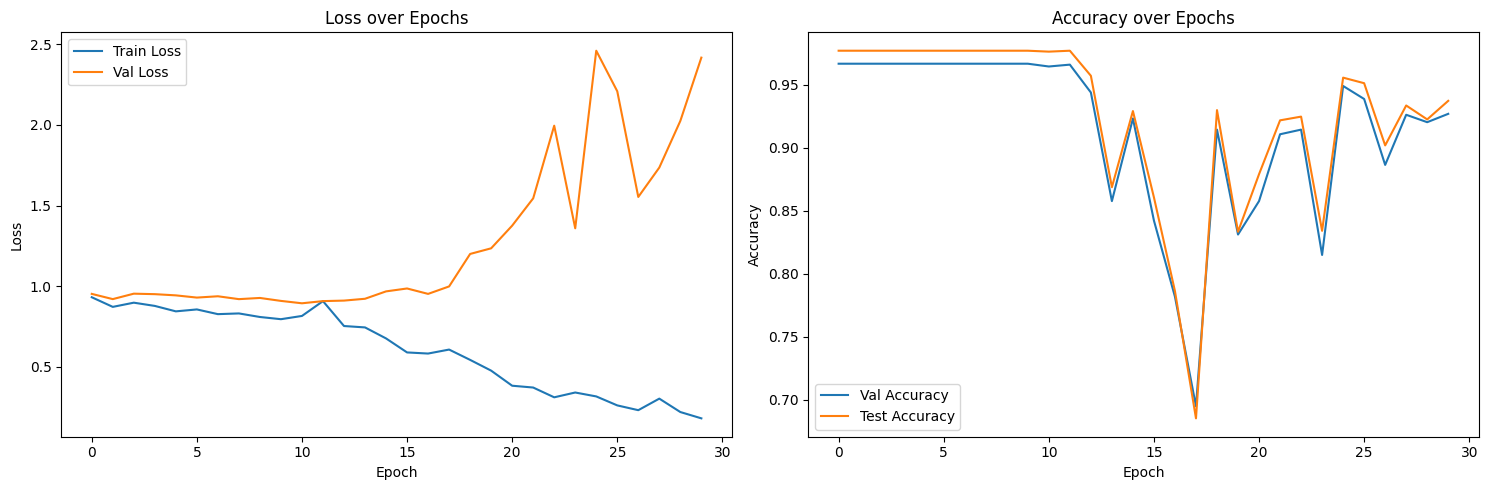

In [ ]:
# Defining the hyperparameters
batch_size = 32
context_size = 100
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 30
weight_decay = 1e-4

# Initializing the model
model = ProteinCNN1D(vocab_size=21, context_size=context_size, conv_channels=512, use_bias=False)
model.to(DEVICE)

# Initializing the AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Computing the pos_weight for class weight calculation
neg_count = train_labels_signal.count(0)
pos_count = train_labels_signal.count(1)
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float).to(DEVICE)

# Storing the results in empty lists for further visualization
train_losses, val_losses, val_accuracies, test_losses, test_accuracies = [], [], [], [], []

# Defining the evaluation loop
def evaluate(model, data_iter, pos_weight):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y, pos_weight=pos_weight)
            total_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
            correct += (preds == y.cpu().numpy()).sum()
            total += y.size(0)
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())

    acc = correct / total
    return total_loss / len(data_iter), acc, all_labels, all_preds

# Initializing the training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in train_iter_reg:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y, pos_weight=pos_weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / len(train_iter_reg)
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation and Test Set Evaluation
    val_loss, val_acc, _, _ = evaluate(model, val_iter_reg, pos_weight)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    test_loss, test_acc, all_labels, all_preds = evaluate(model, test_iter_reg, pos_weight)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1:02d} | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Val Acc: {val_acc:.4f} | '
          f'Test Acc: {test_acc:.4f}')


# Classification report at the end of training
print(classification_report(all_labels, all_preds, digits=4))

# Plotting the loss and accuracy trends
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


From the results, we can see the model cannot predict 1s very well compared to the 0s.